# Shallow Baselines (CIFAR-10 + GTSRB)

This notebook runs the full shallow ML pipeline **for both datasets**:
- Feature A: **3D Color Histogram**
- Feature B: **BoVW (SIFT + k-means)**
- Models: **Linear SVM** and **Logistic Regression**
- Hyperparameter tuning via **GridSearchCV**
- Runtime breakdown:
  - **Train total = feature_train_time + model_train_time**
  - **Test total = feature_test_time + model_test_time**
- Saves plots into `runs_ml/` and also shows them in output.


In [69]:
import os, time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.cluster import MiniBatchKMeans


## 1) Load datasets (repo loaders)

We use the repo’s loaders. CIFAR and GTSRB live in different folders, so we set two roots:
- `data/` for CIFAR
- `data/GTSRB/` for GTSRB


In [70]:
CIFAR_ROOT = "data"
GTSRB_ROOT = "data/GTSRB"

from data.cifar_loader import get_cifar10_dataloaders
from data.gtsrb_loader import get_gtsrb_dataloaders

def get_loaders(dataset_name: str, batch_size: int = 128):
    dataset_name = dataset_name.lower().strip()
    if dataset_name == "cifar":
        return get_cifar10_dataloaders(root=CIFAR_ROOT, batch_size=batch_size, normalize=False)
    elif dataset_name == "gtsrb":
        return get_gtsrb_dataloaders(root=GTSRB_ROOT, batch_size=batch_size, normalize=False, img_size=(64,64))
    else:
        raise ValueError("dataset_name must be 'cifar' or 'gtsrb'")


## 2) Convert DataLoader → NumPy arrays

Classical ML expects NumPy arrays, so we convert the PyTorch DataLoader batches into:
- `X`: `(N, C, H, W)` float in `[0,1]`
- `y`: `(N,)` class labels


In [71]:
def loader_to_numpy(loader, max_items=None):
    X_list, y_list = [], []
    total = 0

    for xb, yb in loader:
        X_list.append(xb.detach().cpu().numpy())
        y_list.append(yb.detach().cpu().numpy())
        total += xb.shape[0]
        if max_items is not None and total >= max_items:
            break

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)

    if max_items is not None:
        X = X[:max_items]
        y = y[:max_items]

    return X, y


## 3) Visual sanity check: sample images

We show a few samples from each dataset to confirm correct loading.


e:\ML_UE3\data\cifar_loader.py:10: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  return pickle.load(f, encoding="bytes")


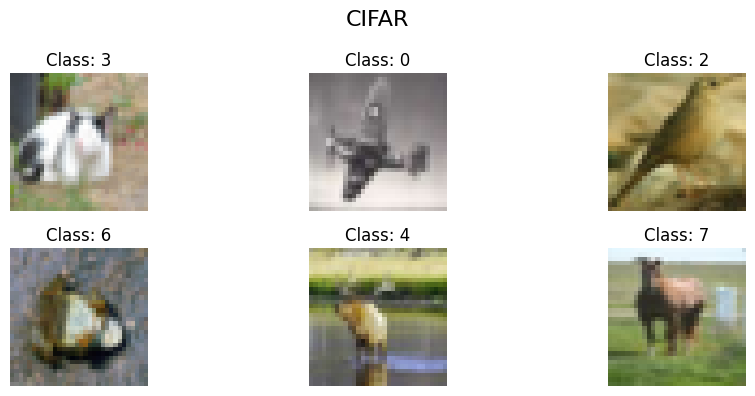

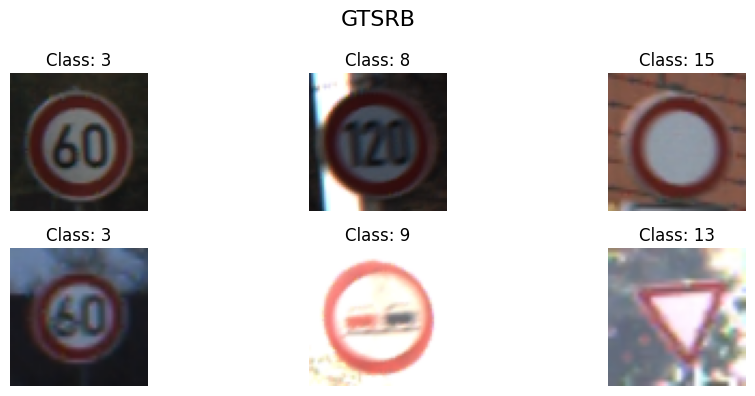

In [72]:
def show_samples(ds, n=6):
    train_loader, _ = get_loaders(ds, batch_size=128)
    xb, yb = next(iter(train_loader))

    plt.figure(figsize=(10,4))
    plt.suptitle(ds.upper(), fontsize=16)

    for i in range(n):
        img = xb[i].permute(1,2,0).cpu().numpy()
        plt.subplot(2, 3, i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"Class: {int(yb[i])}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples("cifar")
show_samples("gtsrb")


## 4) Feature A: 3D color histogram

We compute a 3D histogram across RGB channels (OpenCV uses BGR internally).
With `bins=8`, the feature size is `8^3 = 512`.


In [73]:
def color_hist_3d_features(X, bins=8):
    feats = []
    for i in range(X.shape[0]):
        img_hwc = np.transpose(X[i], (1,2,0))
        img = (img_hwc * 255.0).astype(np.uint8)
        img_bgr = img[:, :, ::-1].copy()

        hist_3d = cv2.calcHist([img_bgr], [0,1,2], None,
                               [bins, bins, bins],
                               [0,256, 0,256, 0,256])
        f = hist_3d.flatten().astype(np.float32)
        f = f / (f.sum() + 1e-8)   # L1 normalize
        feats.append(f)
    return np.vstack(feats)

# ===== SHOW OUTPUT: Histogram features for BOTH datasets =====

for ds in ["cifar", "gtsrb"]:
    print("\n" + "="*60)
    print(f"Histogram features output for dataset: {ds.upper()}")
    print("="*60)

    # load data
    train_loader, test_loader = get_loaders(ds, batch_size=128)
    Xtr, ytr = loader_to_numpy(train_loader, max_items=2000)
    Xte, yte = loader_to_numpy(test_loader,  max_items=500)

    # extract histogram features
    Xtr_hist = color_hist_3d_features(Xtr, bins=8)
    Xte_hist = color_hist_3d_features(Xte, bins=8)

    # print shapes
    print("Train images shape:", Xtr.shape)
    print("Train histogram shape:", Xtr_hist.shape)
    print("Test images shape:", Xte.shape)
    print("Test histogram shape:", Xte_hist.shape)

    # sanity check: first feature vector
    print("First histogram vector (first 10 values):")
    print(Xtr_hist[0][:10])
    print("Sum of histogram (should be 1.0):", Xtr_hist[0].sum())



Histogram features output for dataset: CIFAR


e:\ML_UE3\data\cifar_loader.py:10: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  return pickle.load(f, encoding="bytes")


Train images shape: (2000, 3, 32, 32)
Train histogram shape: (2000, 512)
Test images shape: (500, 3, 32, 32)
Test histogram shape: (500, 512)
First histogram vector (first 10 values):
[0.01660156 0.         0.         0.         0.         0.
 0.         0.         0.09960938 0.05175781]
Sum of histogram (should be 1.0): 1.0

Histogram features output for dataset: GTSRB
Train images shape: (2000, 3, 64, 64)
Train histogram shape: (2000, 512)
Test images shape: (500, 3, 64, 64)
Test histogram shape: (500, 512)
First histogram vector (first 10 values):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum of histogram (should be 1.0): 1.0


e:\ML_UE3\data\cifar_loader.py:10: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  return pickle.load(f, encoding="bytes")


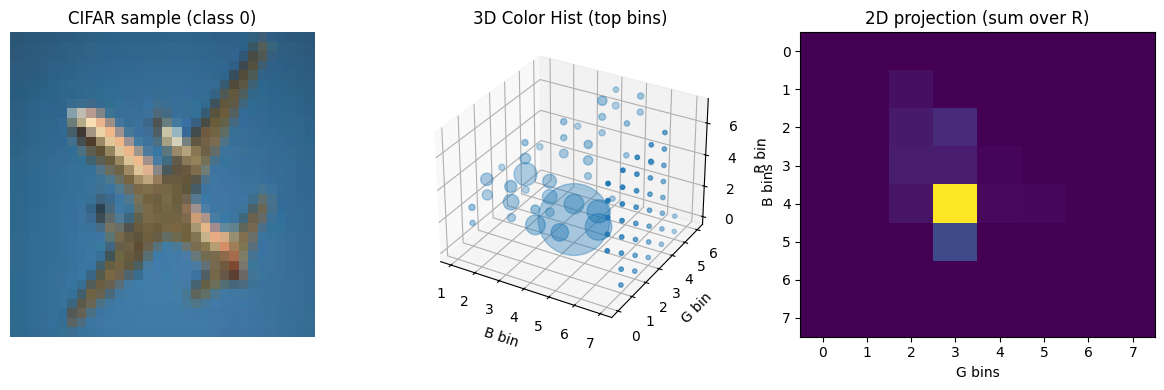

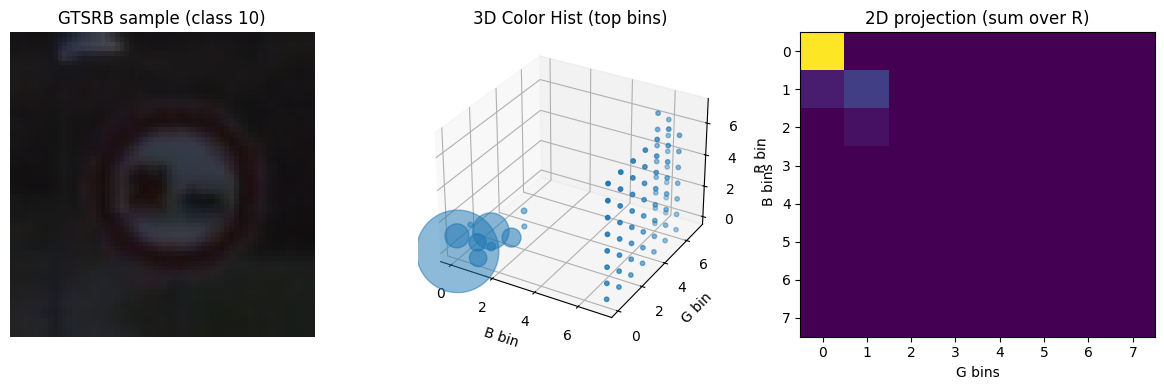

In [74]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_3d_hist_for_one_image(ds, bins=8):
    train_loader, _ = get_loaders(ds, batch_size=128)
    xb, yb = next(iter(train_loader))

    # take first image
    img = xb[0].permute(1,2,0).cpu().numpy()
    img_uint8 = (img * 255).astype(np.uint8)

    # OpenCV expects BGR
    img_bgr = img_uint8[:, :, ::-1].copy()

    # 3D histogram (bins x bins x bins)
    H = cv2.calcHist([img_bgr], [0,1,2], None, [bins, bins, bins], [0,256, 0,256, 0,256]).astype(np.float32)
    H = H / (H.sum() + 1e-8)

    # --- 3D scatter plot of histogram bins ---
    r, g, b = np.indices((bins, bins, bins))
    vals = H.flatten()

    # pick top bins so it’s readable
    topk = min(80, vals.size)
    idx = np.argsort(vals)[-topk:]

    xs = r.flatten()[idx]
    ys = g.flatten()[idx]
    zs = b.flatten()[idx]
    ws = vals[idx]

    fig = plt.figure(figsize=(12,4))

    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(img_uint8)
    ax1.set_title(f"{ds.upper()} sample (class {int(yb[0])})")
    ax1.axis("off")

    ax2 = fig.add_subplot(1,3,2, projection="3d")
    ax2.scatter(xs, ys, zs, s=(ws * 5000 + 10))
    ax2.set_title("3D Color Hist (top bins)")
    ax2.set_xlabel("B bin")
    ax2.set_ylabel("G bin")
    ax2.set_zlabel("R bin")

    # --- 2D projection heatmap: sum over one axis ---
    ax3 = fig.add_subplot(1,3,3)
    proj = H.sum(axis=2)  # sum over R dimension -> (B,G)
    ax3.imshow(proj, aspect="auto")
    ax3.set_title("2D projection (sum over R)")
    ax3.set_xlabel("G bins")
    ax3.set_ylabel("B bins")

    plt.tight_layout()
    plt.show()

# OUTPUT PICTURES for both datasets
plot_3d_hist_for_one_image("cifar", bins=8)
plot_3d_hist_for_one_image("gtsrb", bins=8)


## 5) Feature B: Bag of Visual Words (BoVW) using SIFT + k-means

Steps:
1. Extract SIFT descriptors
2. Fit k-means (MiniBatchKMeans) on a subset (for speed)
3. Represent each image as a histogram of visual words

We use a faster configuration to keep runtime manageable.


In [75]:
class BOV:
    def __init__(self, no_clusters=50, max_desc_per_img=80, max_images_for_kmeans=2000):
        self.no_clusters = no_clusters
        self.max_desc_per_img = max_desc_per_img
        self.max_images_for_kmeans = max_images_for_kmeans
        self.kmeans = MiniBatchKMeans(n_clusters=no_clusters, random_state=0, batch_size=4096)
        self.sift = cv2.SIFT_create()
        self.trained = False

    def _to_gray(self, img_chw):
        img = (np.transpose(img_chw, (1,2,0)) * 255.0).astype(np.uint8)
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    def _extract_descs(self, X):
        all_desc, per_img = [], []
        for i in range(X.shape[0]):
            gray = self._to_gray(X[i])
            _, desc = self.sift.detectAndCompute(gray, None)

            if desc is None:
                per_img.append(None)
                continue

            if desc.shape[0] > self.max_desc_per_img:
                desc = desc[:self.max_desc_per_img]

            desc = desc.astype(np.float32)
            per_img.append(desc)
            all_desc.append(desc)

        all_desc = np.vstack(all_desc) if len(all_desc) else np.zeros((0,128), np.float32)
        return all_desc, per_img

    def _build_hist(self, per_img):
        Xb = np.zeros((len(per_img), self.no_clusters), dtype=np.float32)
        for i, desc in enumerate(per_img):
            if desc is None:
                continue
            words = self.kmeans.predict(desc)
            hist = np.bincount(words, minlength=self.no_clusters).astype(np.float32)
            Xb[i] = hist / (hist.sum() + 1e-8)
        return Xb

    def train_model(self, X_train):
        X_sub = X_train[:min(len(X_train), self.max_images_for_kmeans)]
        all_desc, _ = self._extract_descs(X_sub)
        if all_desc.shape[0] == 0:
            raise RuntimeError("No SIFT descriptors found.")
        self.kmeans.fit(all_desc)
        self.trained = True
        _, per_img_full = self._extract_descs(X_train)
        return self._build_hist(per_img_full)

    def test_model(self, X_test):
        if not self.trained:
            raise RuntimeError("Call train_model first.")
        _, per_img = self._extract_descs(X_test)
        return self._build_hist(per_img)
    
# ===== SHOW OUTPUT: BoVW (SIFT) features for BOTH datasets =====

for ds in ["cifar", "gtsrb"]:
    print("\n" + "="*60)
    print(f"BoVW (SIFT) features output for dataset: {ds.upper()}")
    print("="*60)

    # load a small subset (BoVW is slower)
    train_loader, test_loader = get_loaders(ds, batch_size=128)
    Xtr, ytr = loader_to_numpy(train_loader, max_items=500)
    Xte, yte = loader_to_numpy(test_loader,  max_items=200)

    print("Train images shape:", Xtr.shape)
    print("Test images shape :", Xte.shape)

    # build BoVW features
    bov = BOV(no_clusters=50, max_desc_per_img=80, max_images_for_kmeans=500)

    t0 = time.perf_counter()
    Xtr_bovw = bov.train_model(Xtr)
    train_feat_time = time.perf_counter() - t0

    t0 = time.perf_counter()
    Xte_bovw = bov.test_model(Xte)
    test_feat_time = time.perf_counter() - t0

    # print shapes
    print("Train BoVW shape:", Xtr_bovw.shape)
    print("Test BoVW shape :", Xte_bovw.shape)

    # sanity check: vector size + normalization
    print("First BoVW vector (first 10 values):")
    print(Xtr_bovw[0][:10])
    print("Sum of BoVW hist (should be 1.0 or ~1.0):", float(Xtr_bovw[0].sum()))

    # timing info
    print(f"BoVW feature time (train): {train_feat_time:.2f} s")
    print(f"BoVW feature time (test) : {test_feat_time:.2f} s")


BoVW (SIFT) features output for dataset: CIFAR


e:\ML_UE3\data\cifar_loader.py:10: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  return pickle.load(f, encoding="bytes")


Train images shape: (500, 3, 32, 32)
Test images shape : (200, 3, 32, 32)
Train BoVW shape: (500, 50)
Test BoVW shape : (200, 50)
First BoVW vector (first 10 values):
[0.         0.         0.         0.         0.11111111 0.
 0.         0.         0.         0.        ]
Sum of BoVW hist (should be 1.0 or ~1.0): 1.0
BoVW feature time (train): 1.42 s
BoVW feature time (test) : 0.23 s

BoVW (SIFT) features output for dataset: GTSRB
Train images shape: (500, 3, 64, 64)
Test images shape : (200, 3, 64, 64)
Train BoVW shape: (500, 50)
Test BoVW shape : (200, 50)
First BoVW vector (first 10 values):
[0.         0.         0.         0.         0.         0.
 0.         0.07142857 0.         0.        ]
Sum of BoVW hist (should be 1.0 or ~1.0): 1.0
BoVW feature time (train): 2.08 s
BoVW feature time (test) : 0.33 s


e:\ML_UE3\data\cifar_loader.py:10: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  return pickle.load(f, encoding="bytes")


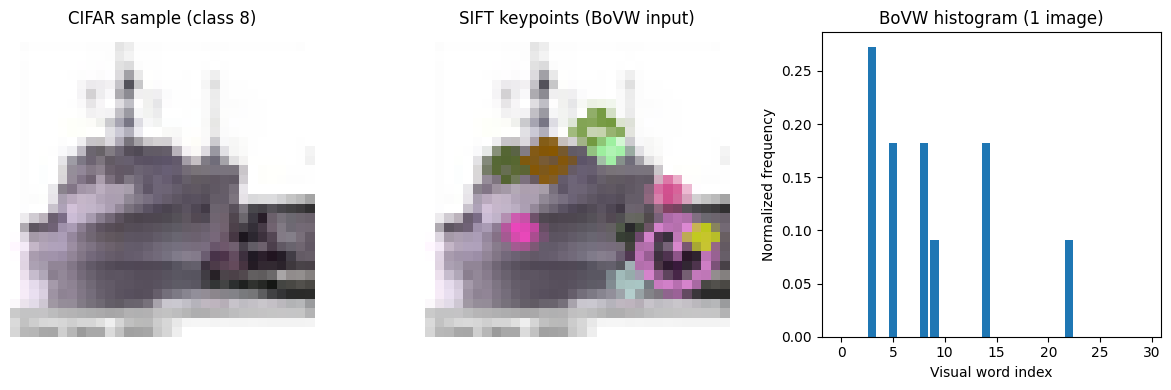

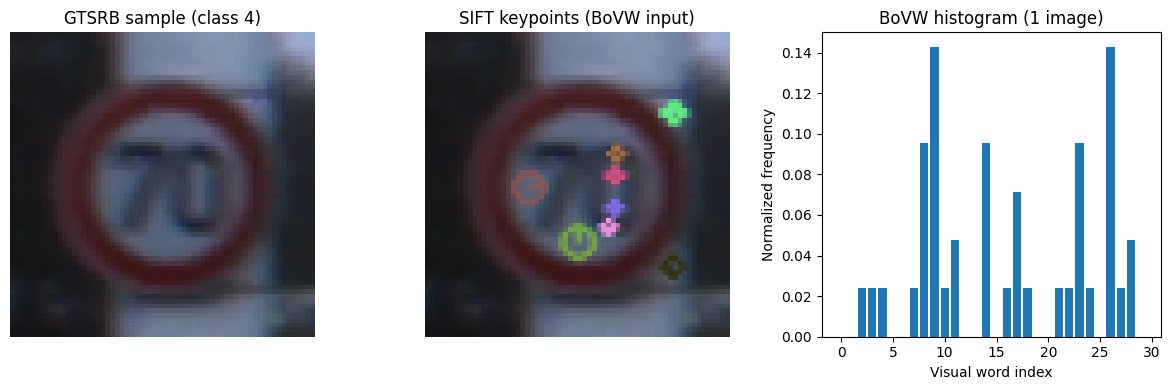

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_bovw_output(ds, no_clusters=30):
    train_loader, _ = get_loaders(ds, batch_size=128)
    xb, yb = next(iter(train_loader))

    img = xb[0].permute(1,2,0).cpu().numpy()
    img_uint8 = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)

    # SIFT keypoints visualization
    sift = cv2.SIFT_create()
    keypoints, desc = sift.detectAndCompute(gray, None)
    img_kp = cv2.drawKeypoints(
        img_uint8, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # Build BoVW on a small subset (fast)
    Xtr, ytr = loader_to_numpy(train_loader, max_items=400)

    bov = BOV(no_clusters=no_clusters, max_desc_per_img=80, max_images_for_kmeans=400)
    Xtr_bovw = bov.train_model(Xtr)

    # BoVW histogram vector for the first image in Xtr
    hist = Xtr_bovw[0]

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img_uint8)
    plt.title(f"{ds.upper()} sample (class {int(yb[0])})")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(img_kp)
    plt.title("SIFT keypoints (BoVW input)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.bar(np.arange(no_clusters), hist)
    plt.title("BoVW histogram (1 image)")
    plt.xlabel("Visual word index")
    plt.ylabel("Normalized frequency")

    plt.tight_layout()
    plt.show()

# OUTPUT PICTURES for both datasets
plot_bovw_output("cifar", no_clusters=30)
plot_bovw_output("gtsrb", no_clusters=30)


## 6) Shallow models + hyperparameter tuning

We evaluate:
- **Linear SVM (LinearSVC)**
- **Logistic Regression**

We tune **~3 hyperparameters** per model:
- SVM: `C`, `penalty`, `class_weight`
- LR: `C`, `class_weight`, `fit_intercept`

We also measure:
- model training time (CV + fit)
- model prediction time


In [77]:
def run_cv_timed(Xtr, ytr, Xte, yte, model="svm", scale=False):
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))

    if model == "svm":
        clf = LinearSVC(max_iter=30000)
        param_grid = {
            "clf__C": [0.1, 1, 10],
            "clf__penalty": ["l2"],
        }

    elif model == "lr":
        clf = LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            max_iter=3000
        )
        param_grid = {
            "clf__C": [0.1, 1, 10],
            "clf__l1_ratio": [0.0, 0.5, 1.0],
        }
    else:
        raise ValueError

    steps.append(("clf", clf))
    pipe = Pipeline(steps)

    grid = GridSearchCV(
        pipe,
        param_grid,
        cv=2,
        scoring="balanced_accuracy",
        n_jobs=-1
    )

    t0 = time.perf_counter()
    grid.fit(Xtr, ytr)
    train_time = time.perf_counter() - t0

    best = grid.best_estimator_

    t0 = time.perf_counter()
    y_pred = best.predict(Xte)
    test_time = time.perf_counter() - t0

    return {
        "best_params": grid.best_params_,
        "accuracy": accuracy_score(yte, y_pred),
        "balanced_accuracy": balanced_accuracy_score(yte, y_pred),
        "confusion_matrix": confusion_matrix(yte, y_pred),
        "model_train_time": train_time,
        "model_test_time": test_time,
    }


In [ ]:
import time  # make sure this exists somewhere above (imports cell)

def run_everything_for_dataset(ds):
    print("Loading data...")
    train_loader, test_loader = get_loaders(ds)

    Xtr, ytr = loader_to_numpy(train_loader, max_items=2000)
    Xte, yte = loader_to_numpy(test_loader,  max_items=500)

    # -----------------------------
    # Feature A: 3D Color Histogram (TIMED)
    # -----------------------------
    print("Extracting Histogram...")
    t0 = time.perf_counter()
    Xtr_hist = color_hist_3d_features(Xtr)
    hist_train_feat_time = time.perf_counter() - t0

    t0 = time.perf_counter()
    Xte_hist = color_hist_3d_features(Xte)
    hist_test_feat_time = time.perf_counter() - t0

    print(f"Histogram feature time (train/test): {hist_train_feat_time:.2f}s / {hist_test_feat_time:.2f}s")

    # -----------------------------
    # Feature B: BoVW (SIFT) (TIMED)
    # -----------------------------
    print("Extracting BoVW...")
    bov = BOV(no_clusters=30)

    t0 = time.perf_counter()
    Xtr_bov = bov.train_model(Xtr)
    bov_train_feat_time = time.perf_counter() - t0

    t0 = time.perf_counter()
    Xte_bov = bov.test_model(Xte)
    bov_test_feat_time = time.perf_counter() - t0

    print(f"BoVW feature time (train/test): {bov_train_feat_time:.2f}s / {bov_test_feat_time:.2f}s")

    # -----------------------------
    # Train + evaluate models
    # -----------------------------
    print("Training models...")
    res = {}
    res["Hist+SVM"] = run_cv_timed(Xtr_hist, ytr, Xte_hist, yte, "svm", False)
    res["Hist+LR"]  = run_cv_timed(Xtr_hist, ytr, Xte_hist, yte, "lr",  False)
    res["BoVW+SVM"] = run_cv_timed(Xtr_bov,  ytr, Xte_bov,  yte, "svm", True)
    res["BoVW+LR"]  = run_cv_timed(Xtr_bov,  ytr, Xte_bov,  yte, "lr",  True)

    print("\n=== RESULTS for", ds.upper(), "===")
    for name, r in res.items():
        print(f"{name:10s} | acc={r['accuracy']:.4f} | bacc={r['balanced_accuracy']:.4f} | best={r['best_params']}")
    print("==============================\n")

    # -----------------------------
    # attach FULL times (feature + model) into each model result
    # -----------------------------
    res["Hist+SVM"]["train_total_time"] = hist_train_feat_time + res["Hist+SVM"]["model_train_time"]
    res["Hist+SVM"]["test_total_time"]  = hist_test_feat_time  + res["Hist+SVM"]["model_test_time"]

    res["Hist+LR"]["train_total_time"]  = hist_train_feat_time + res["Hist+LR"]["model_train_time"]
    res["Hist+LR"]["test_total_time"]   = hist_test_feat_time  + res["Hist+LR"]["model_test_time"]

    res["BoVW+SVM"]["train_total_time"] = bov_train_feat_time  + res["BoVW+SVM"]["model_train_time"]
    res["BoVW+SVM"]["test_total_time"]  = bov_test_feat_time   + res["BoVW+SVM"]["model_test_time"]

    res["BoVW+LR"]["train_total_time"]  = bov_train_feat_time  + res["BoVW+LR"]["model_train_time"]
    res["BoVW+LR"]["test_total_time"]   = bov_test_feat_time   + res["BoVW+LR"]["model_test_time"]

    return res


In [79]:
all_results = {}

for ds in ["cifar", "gtsrb"]:
    print("\n" + "="*80)
    print(f"START DATASET: {ds}")
    print("="*80)

    all_results[ds] = run_everything_for_dataset(ds)

    print(f"END DATASET: {ds}")
    print("="*80)

print("\nDONE: whole pipeline finished for CIFAR + GTSRB")



START DATASET: cifar
Loading data...


e:\ML_UE3\data\cifar_loader.py:10: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  return pickle.load(f, encoding="bytes")


Extracting Histogram...
Extracting BoVW...
Training models...


e:\ML_UE3\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
e:\ML_UE3\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



=== RESULTS for CIFAR ===
Hist+SVM   | acc=0.2740 | bacc=0.2666 | best={'clf__C': 1, 'clf__penalty': 'l2'}
Hist+LR    | acc=0.2980 | bacc=0.2909 | best={'clf__C': 10, 'clf__l1_ratio': 0.0}
BoVW+SVM   | acc=0.1960 | bacc=0.1924 | best={'clf__C': 1, 'clf__penalty': 'l2'}
BoVW+LR    | acc=0.1980 | bacc=0.1954 | best={'clf__C': 1, 'clf__l1_ratio': 0.0}



NameError: name 'hist_train_feat_time' is not defined

## 7) End-to-end experiment (CIFAR + GTSRB)

For each dataset:
1. Load data (limited size for speed)
2. Extract histogram features (timed)
3. Extract BoVW features (timed)
4. Train SVM and LR with GridSearchCV (timed)
5. Print accuracy + balanced accuracy + best hyperparameters
6. Print runtime breakdown


In [ ]:
def run_cv_timed(Xtr_feat, ytr, Xte_feat, yte, model="svm", scale=False):
    steps = []

    if scale:
        steps.append(("scaler", StandardScaler()))

    # =======================
    # Linear SVM
    # =======================
    if model == "svm":
        print("  -> Setting up Linear SVM")

        clf = LinearSVC(
            dual=False,
            max_iter=5000
        )

        steps.append(("clf", clf))
        pipe = Pipeline(steps)

        param_grid = {
            "clf__C": [0.1, 1, 10],
            "clf__penalty": ["l2"],
        }

    # =======================
    # Logistic Regression (Elastic-Net)
    # =======================
    elif model == "lr":
        print("  -> Setting up Logistic Regression (elastic-net)")

        clf = LogisticRegression(
            penalty="elasticnet",
            solver="saga",
            max_iter=3000
        )

        steps.append(("clf", clf))
        pipe = Pipeline(steps)

        param_grid = {
            "clf__C": [0.1, 1, 10],
            "clf__l1_ratio": [0.0, 0.5, 1.0],   # L2 -> elastic -> L1
        }

    else:
        raise ValueError("model must be 'svm' or 'lr'")

    # =======================
    # GridSearch + timing
    # =======================
    print(f"  -> Running GridSearchCV ({len(param_grid)} hyperparameters)")
    print("  -> Fitting models (this may take a while)...")

    grid = GridSearchCV(
        pipe,
        param_grid,
        cv=2,
        scoring="balanced_accuracy",
        n_jobs=1,
        error_score="raise"
    )

    t0 = time.perf_counter()
    grid.fit(Xtr_feat, ytr)
    model_train_time = time.perf_counter() - t0

    print("  -> GridSearch done.")
    print("  -> Best parameters:", grid.best_params_)

    best_model = grid.best_estimator_

    # =======================
    # Test time
    # =======================
    print("  -> Running prediction on test set...")

    t0 = time.perf_counter()
    y_pred = best_model.predict(Xte_feat)
    model_test_time = time.perf_counter() - t0

    print("  -> Prediction done.")

    return {
        "best_params": grid.best_params_,
        "accuracy": accuracy_score(yte, y_pred),
        "balanced_accuracy": balanced_accuracy_score(yte, y_pred),
        "confusion_matrix": confusion_matrix(yte, y_pred),
        "model_train_time": model_train_time,
        "model_test_time": model_test_time,
    }


## 8) Save plots to `runs_ml/` and show them in output

We produce report-ready plots:
- Confusion matrix for best model
- Balanced accuracy comparison bar chart
- Train/Test runtime comparison bar charts
- Plus: combined dataset comparison & tradeoff plot


Saved per-dataset plots to: runs_ml


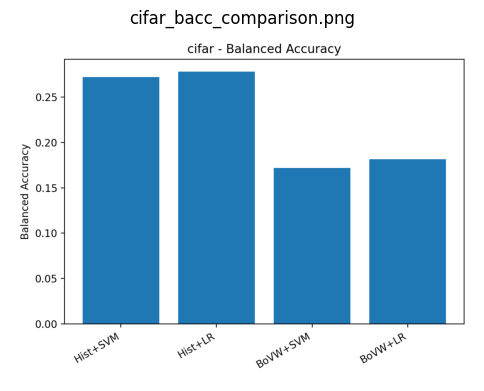

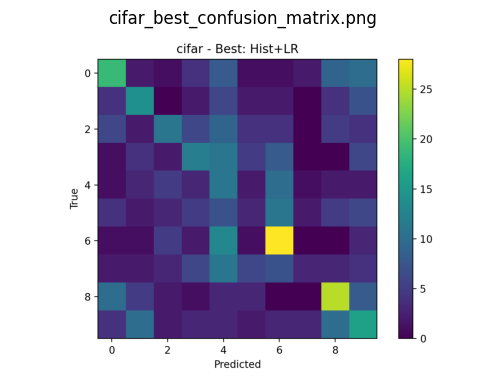

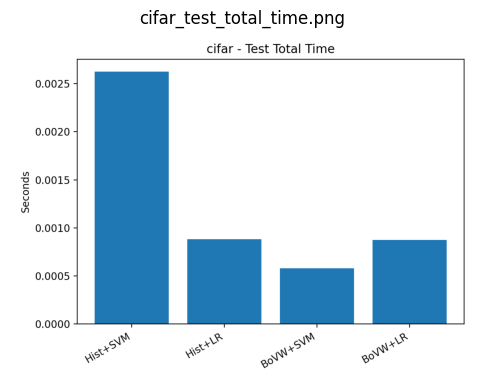

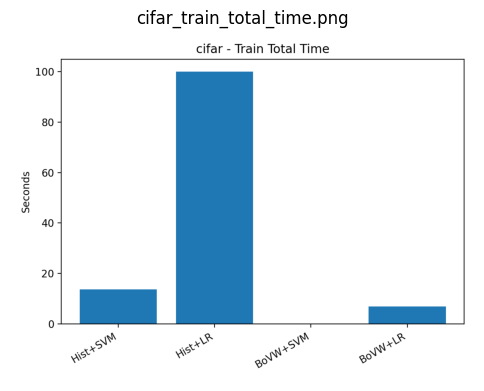

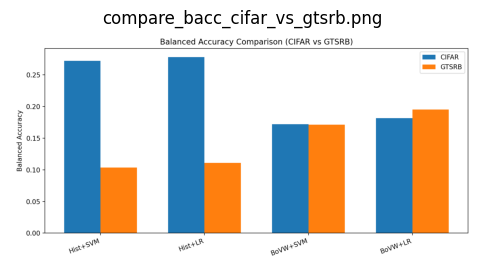

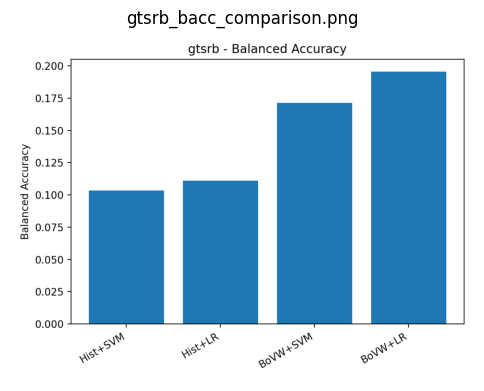

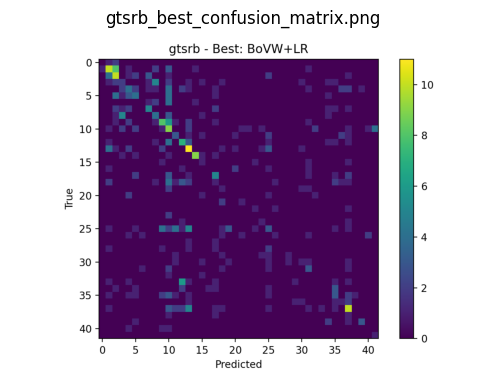

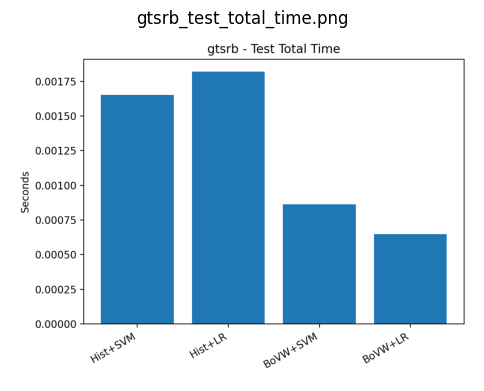

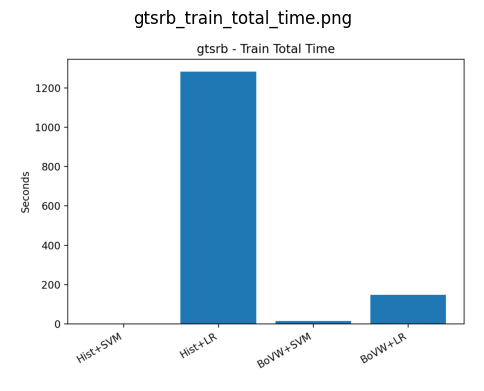

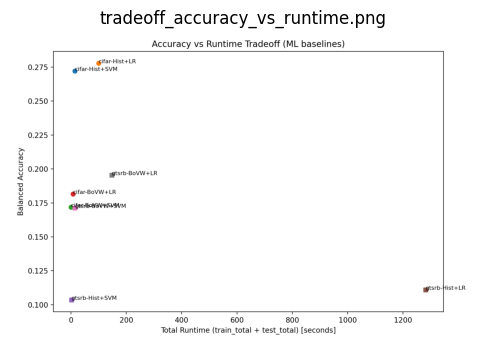

In [ ]:
RUN_DIR = "runs_ml"
os.makedirs(RUN_DIR, exist_ok=True)

def save_confusion_matrix(cm, title, outpath):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()

def save_bar(values_dict, title, ylabel, outpath):
    names = list(values_dict.keys())
    vals = [values_dict[k] for k in names]
    plt.figure()
    plt.bar(names, vals)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()

# save per-dataset plots
for ds_name, res in all_results.items():
    best_name = max(res.keys(), key=lambda k: res[k]["balanced_accuracy"])
    best_res = res[best_name]

    save_confusion_matrix(
        best_res["confusion_matrix"],
        title=f"{ds_name} - Best: {best_name}",
        outpath=os.path.join(RUN_DIR, f"{ds_name}_best_confusion_matrix.png")
    )

    bacc_dict = {k: v["balanced_accuracy"] for k, v in res.items()}
    save_bar(bacc_dict, f"{ds_name} - Balanced Accuracy", "Balanced Accuracy",
             os.path.join(RUN_DIR, f"{ds_name}_bacc_comparison.png"))

    
    train_total = {k: v["model_train_time"] for k, v in res.items()}
    test_total  = {k: v["model_test_time"]  for k, v in res.items()}
    save_bar(train_total, f"{ds_name} - Train Total Time", "Seconds",
             os.path.join(RUN_DIR, f"{ds_name}_train_total_time.png"))
    save_bar(test_total, f"{ds_name} - Test Total Time", "Seconds",
             os.path.join(RUN_DIR, f"{ds_name}_test_total_time.png"))

print("Saved per-dataset plots to:", RUN_DIR)

# show everything saved
import matplotlib.image as mpimg

pngs = sorted([f for f in os.listdir(RUN_DIR) if f.endswith(".png")])

for fname in pngs:
    plt.figure(figsize=(6, 5))
    img = mpimg.imread(os.path.join(RUN_DIR, fname))
    plt.imshow(img)
    plt.title(fname)
    plt.axis("off")
    plt.show()



## 9) Extra report plots

Two additional plots that are easy to discuss in a report:
1. **Balanced accuracy comparison across datasets**
2. **Accuracy vs runtime tradeoff** (fast vs accurate)


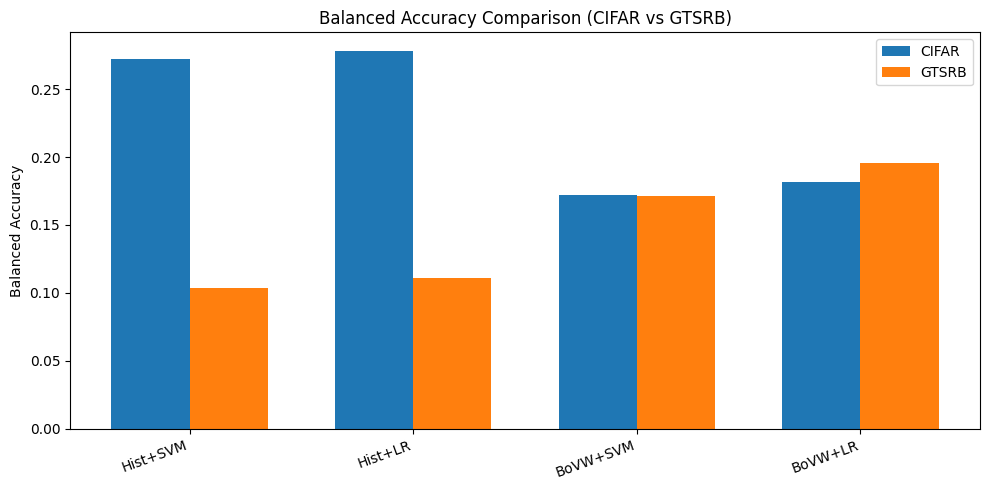

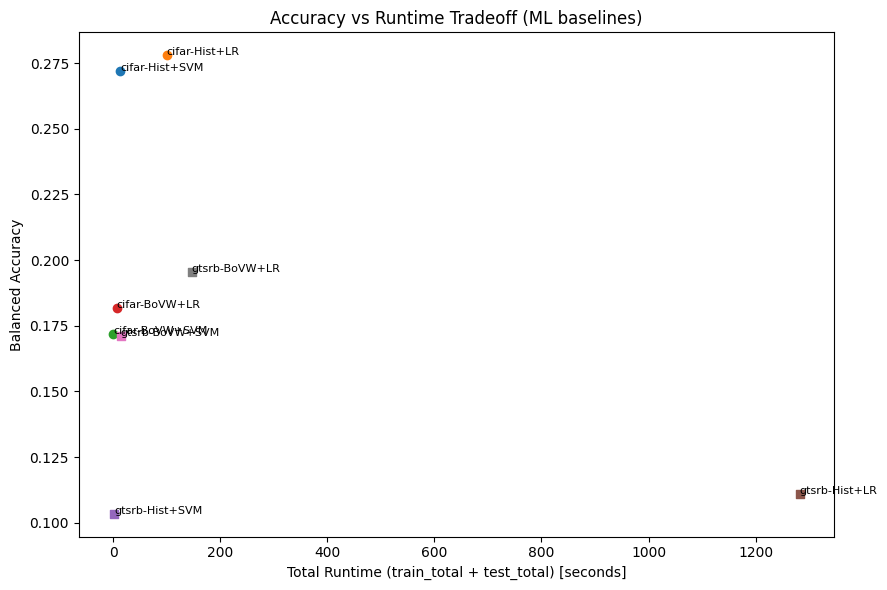

In [ ]:
# --- Plot 1: Balanced accuracy (CIFAR vs GTSRB) side-by-side ---
models = ["Hist+SVM", "Hist+LR", "BoVW+SVM", "BoVW+LR"]
datasets = ["cifar", "gtsrb"]

bacc = np.array([[all_results[ds][m]["balanced_accuracy"] for ds in datasets] for m in models])
x = np.arange(len(models))
w = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - w/2, bacc[:,0], width=w, label="CIFAR")
plt.bar(x + w/2, bacc[:,1], width=w, label="GTSRB")
plt.xticks(x, models, rotation=20, ha="right")
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy Comparison (CIFAR vs GTSRB)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RUN_DIR, "compare_bacc_cifar_vs_gtsrb.png"), dpi=200)
plt.show()

# --- Plot 2: Accuracy vs Runtime tradeoff ---
plt.figure(figsize=(9,6))
markers = {"cifar": "o", "gtsrb": "s"}

for ds in ["cifar", "gtsrb"]:
    for model_name, r in all_results[ds].items():
        total_runtime = r["model_train_time"] + r["model_test_time"]
        plt.scatter(total_runtime, r["balanced_accuracy"], marker=markers[ds])
        plt.text(total_runtime, r["balanced_accuracy"], f"{ds}-{model_name}", fontsize=8)

plt.xlabel("Total Runtime (train_total + test_total) [seconds]")
plt.ylabel("Balanced Accuracy")
plt.title("Accuracy vs Runtime Tradeoff (ML baselines)")
plt.tight_layout()
plt.savefig(os.path.join(RUN_DIR, "tradeoff_accuracy_vs_runtime.png"), dpi=200)
plt.show()


### Notes for the report
- Histogram features are very fast and produce compact (512-D) vectors.
- BoVW is more expensive due to SIFT descriptor extraction + k-means.
- We report both **accuracy** and **balanced accuracy** (balanced accuracy is important for class imbalance).
- Runtime is reported as **feature time + model time** for training and testing.
